In [28]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
config = get_config()
assert config.feat_thresh == 1.

In [30]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [31]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch, dirname, label, toSave: bool = True):
    if "BiPot" in config.data_path:
        ts_type_str = "fBiPot"
    elif "SinLog" in config.data_path:
        ts_type_str = "fSinLog"
    elif "QuadSinHF" in config.data_path:
        ts_type_str = "fQuadSinHF2"
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean - mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs, mean, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"Score Estimator for {label}", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $Y$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
def plot_ewma_losses(epochs, losses):
    start_idx = 50
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.92   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    print(np.min(short_term_ema[start_idx:]), np.min(long_term_ema[start_idx:]))
    print(long_term_ema[-1])
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    return long_term_ema

In [32]:
config = get_config()
#assert config.enforce_fourier_mean_reg
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

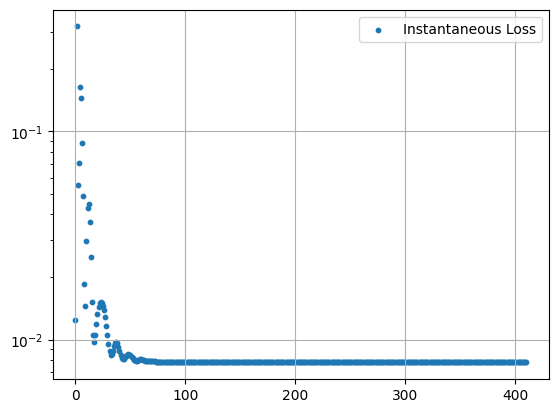

410

In [33]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss"), 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10, label="Instantaneous Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()
plt.close()
Nepochs_losses[-1]

0.007763933852545878 0.007764005857755734
0.007764191469342662


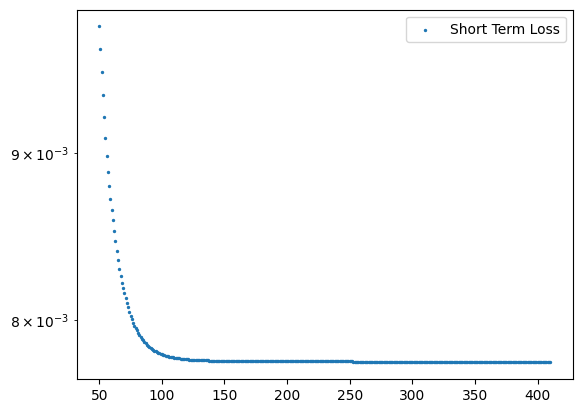

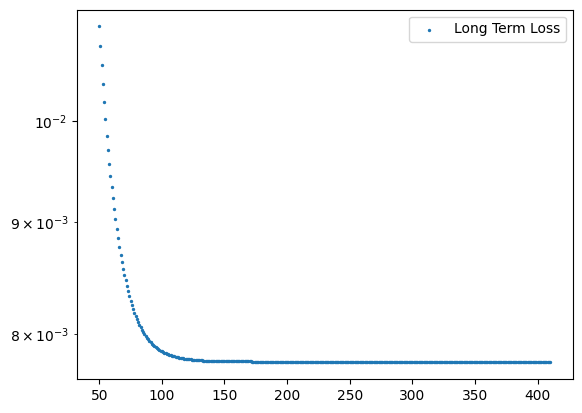

In [34]:
long_term_ema = plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

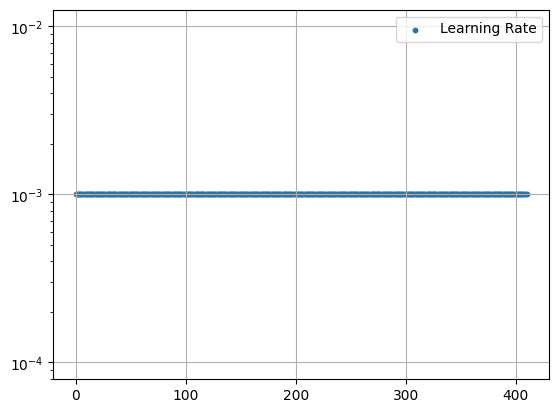

In [35]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss_LR"), 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0
end = -1
plt.scatter(np.arange(LRs.shape[0]),  LRs, s=10, label="Learning Rate")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()
plt.close()

In [36]:
root_score_dir = ""
if "fQuadSin" in config.data_path:
    minx = -1.5
    assert config.sin_space_scale == 25.
    ts_type = "fQuadSin"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/QuadSinHFLessData/"
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/BiPotLessData/"
elif "fSinLog" in config.data_path:
    minx = -1.5
    ts_type = "fSinLog"
    include = (f"{config.deltaT:.3e}dT_{config.log_space_scale}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/SinLogLessData/"
maxx = -minx

In [37]:
root_score_dir

'/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/'

In [38]:
def get_drift_files(config, include, ts_type_str, root_score_dir):
    ts_type = f"{ts_type_str}"
    driftevalexp_files = []
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "MLP" in file and ts_type in file and include in file and "TSPM" in file:
            if (("ST" in ts_type_str and "_ST_" in file) or (("ST" not in ts_type_str and "_ST_" not in file))):
                if "muhats" in file and "DriftEvalExp" in file :
                    driftevalexp_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "true" in file:
                    driftoostrack_true_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "global" in file:
                    driftoostrack_local_files.append(root_score_dir+file)
    def extract_bw_drift_eval_exp_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_bw_drift_eval_exp_number)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    Nepochs_drifteval = [extract_bw_drift_eval_exp_number(f) for f in driftevalexp_files]
    return driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval

In [39]:
NSTgt = "NSTgt" if not config.stable_target else ""
NSTgt += "NFMReg_" if not config.enforce_fourier_mean_reg else ""
if "BiPot" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fBiPot".replace(".", "")
    dirname = "BiPot"
    label = "$\mu_{3}$"
elif "QuadSinHF" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fQuadSinHF".replace(".","")
    dirname = "QuadSinHF2"
    label = "$\mu_{2}$"
elif "SinLog" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fSinLog".replace(".","")
    dirname = "SinLog"
    label = "$\mu_{1}$"
driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval = get_drift_files(config=config, include=include, ts_type_str=ts_type_str, root_score_dir=root_score_dir)

In [40]:
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
best_epoch_eval = 1
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and "EE" in file:
        print(file.split("EENEp")[-1])
        entered = True
        best_epoch_eval = int(file.split("EENEp")[-1])

125


In [41]:
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
best_epoch_track = 1
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and "Trk" in file:
        print(file.split("TrkNEp")[-1])
        entered = True
        best_epoch_track = int(file.split("TrkNEp")[-1])

110


In [42]:
eval_exp_rmses = {}
dfiles = []
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        elif "SinLog" in config.data_path:
            true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale).numpy()
        #print(Nepoch, muhats.shape, true_drifts.shape)
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[2]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        eval_exp_rmses.update({Nepoch: round(rmse, 6)})
        dfiles.append(file)
    except (FileNotFoundError, pickle.UnpicklingError) as e:
        continue
Nepochs_drifteval = np.array(list(eval_exp_rmses.keys())).flatten()
driftevalexp_files = dfiles
eval_exp_rmses

{1: 20548.457031,
 2: 1121.421631,
 3: 3073.967529,
 4: 8233.21875,
 5: 6926.282227,
 6: 3179.69043,
 7: 680.885925,
 8: 0.592166,
 9: 338.998871,
 10: 833.273926,
 11: 1025.375977,
 12: 839.505737,
 13: 477.113586,
 14: 159.494568,
 15: 12.578539,
 16: 8.106676,
 17: 50.935562,
 18: 115.3395,
 19: 177.184265,
 20: 224.061249,
 21: 256.271912,
 22: 271.34375,
 23: 270.85553,
 24: 258.384644,
 25: 234.042908,
 26: 198.500885,
 27: 155.601837,
 28: 107.927956,
 29: 65.478882,
 30: 29.67992,
 31: 7.296314,
 32: 0.584782,
 33: 7.799537,
 34: 24.117111,
 35: 42.25985,
 36: 53.075951,
 37: 54.758896,
 38: 45.604774,
 39: 31.121134,
 40: 16.266769,
 41: 5.843653,
 42: 0.883961,
 43: 1.086343,
 44: 4.641181,
 45: 9.856076,
 46: 14.385348,
 47: 17.361168,
 48: 17.611141,
 49: 16.087471,
 50: 12.791411,
 51: 8.441087,
 52: 4.559797,
 53: 1.618819,
 54: 0.39138,
 55: 0.900383,
 56: 2.762947,
 57: 5.093716,
 58: 7.00799,
 59: 7.927681,
 60: 7.390581,
 61: 5.84873,
 62: 3.922755,
 63: 2.111444,
 64

In [43]:
%%skip
drift_track_rmses = {}
dfiles = []
dfiles_local = []
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true, allow_pickle=True)
        all_local_states= np.load(local,allow_pickle=True)
        print(Nepoch, all_local_states.shape, all_true_states.shape)
        global_error = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        total_local_errors = np.sqrt(np.mean(global_error.reshape(-1, global_error.shape[-1]), axis=0))
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        dfiles.append(true)
        dfiles_local.append(local)
    except pickle.UnpicklingError as e:
        continue
    except (FileNotFoundError, ValueError, TimeoutError) as e:
        continue
Nepochs_track= np.array(list(drift_track_rmses.keys())).flatten()
driftoostrack_true_files = dfiles
driftoostrack_local_files = dfiles_local
print(Nepochs_track)

In [49]:
common_epochs = np.intersect1d(np.intersect1d(np.intersect1d(Nepochs_losses, Nepochs_drifteval), Nepochs_drifteval), np.arange(50, 10000)) #Nepochs_track
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
evalexp_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
eval_rmses = np.array(list(eval_exp_rmses.values()))[evalexp_idx]
track_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs] # Nepochs_track
track_rmses = np.array(list(eval_exp_rmses.values()))[track_idx] #drift_track_rmses

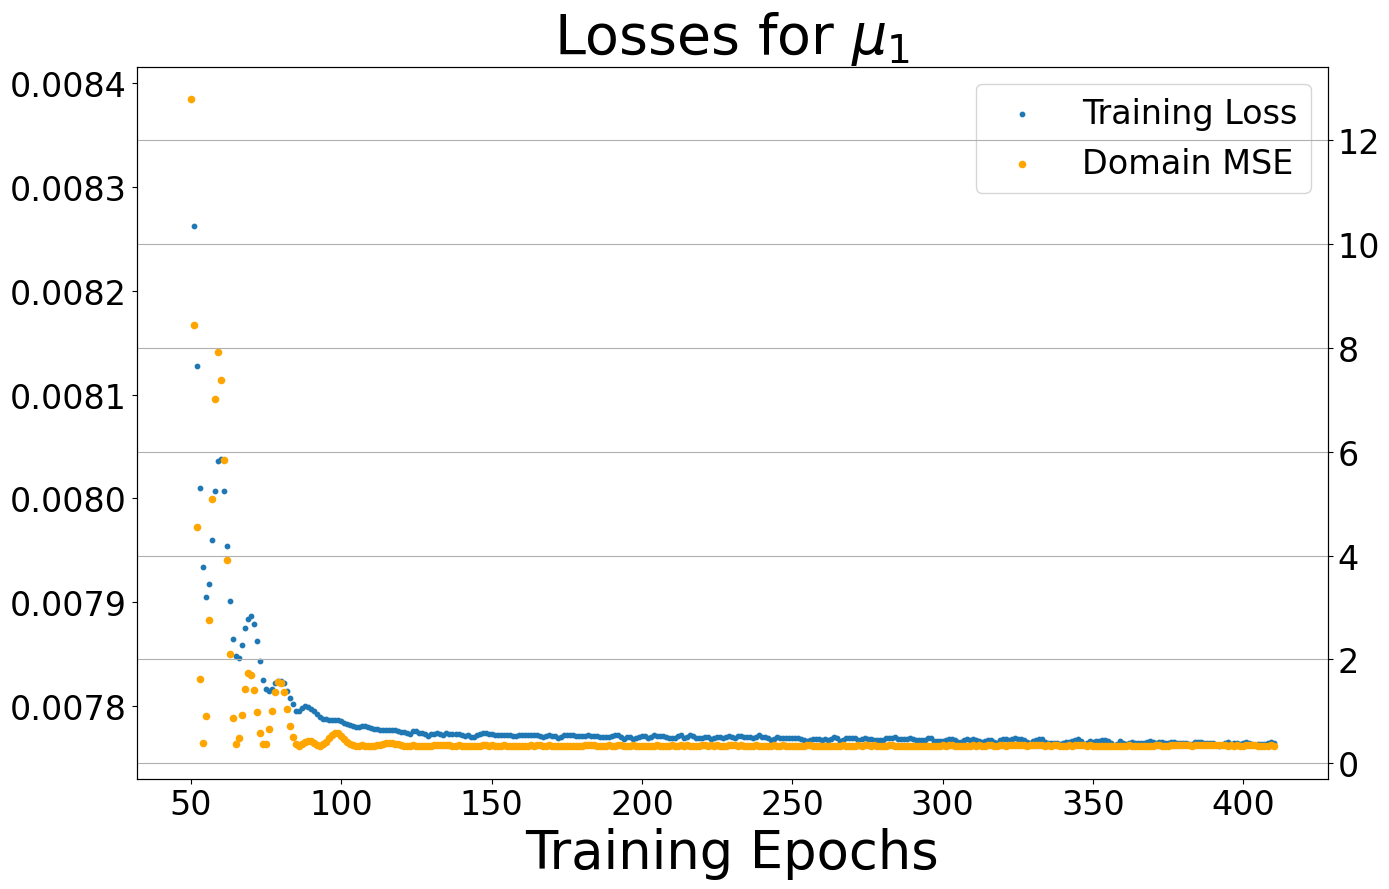

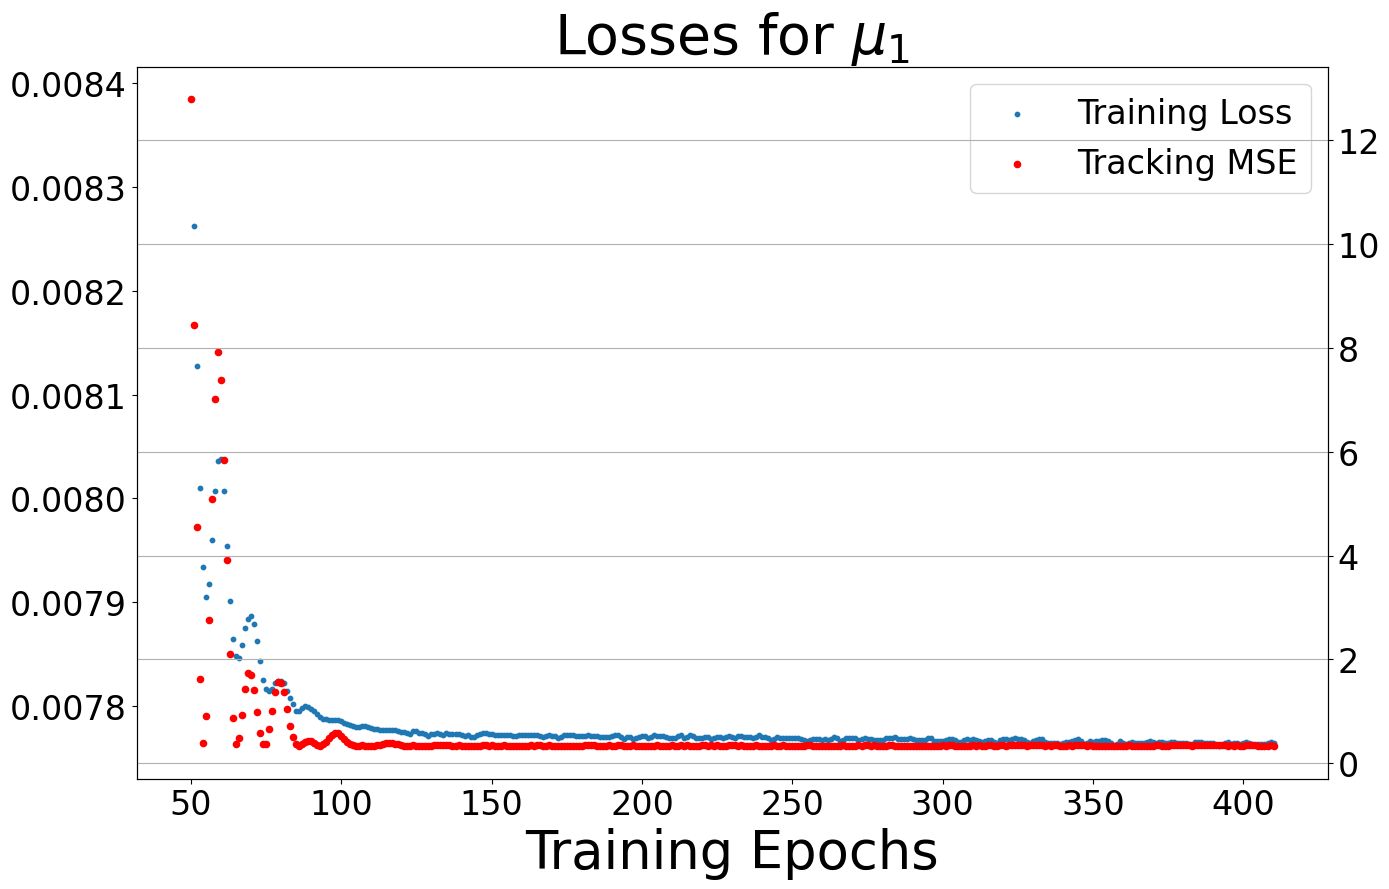

In [50]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesEvalExp_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()

(50, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_1Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
20548.45703125
torch.Size([256, 100])
(256,)


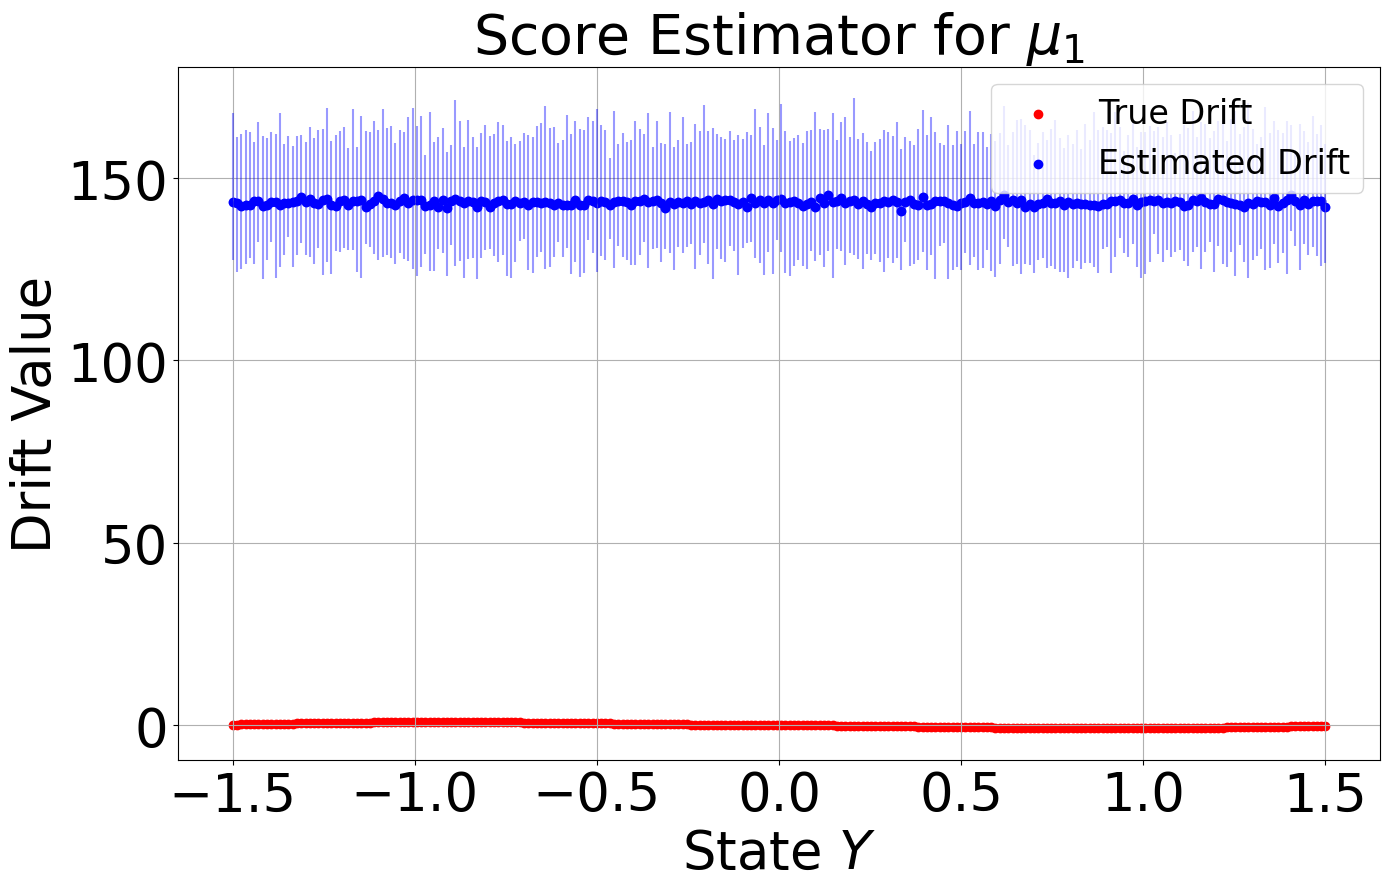

MSE 20548.45703125 at Nepoch 50

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_1Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(51, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_2Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
1121.421630859375
torch.Size([256, 100])
(256,)


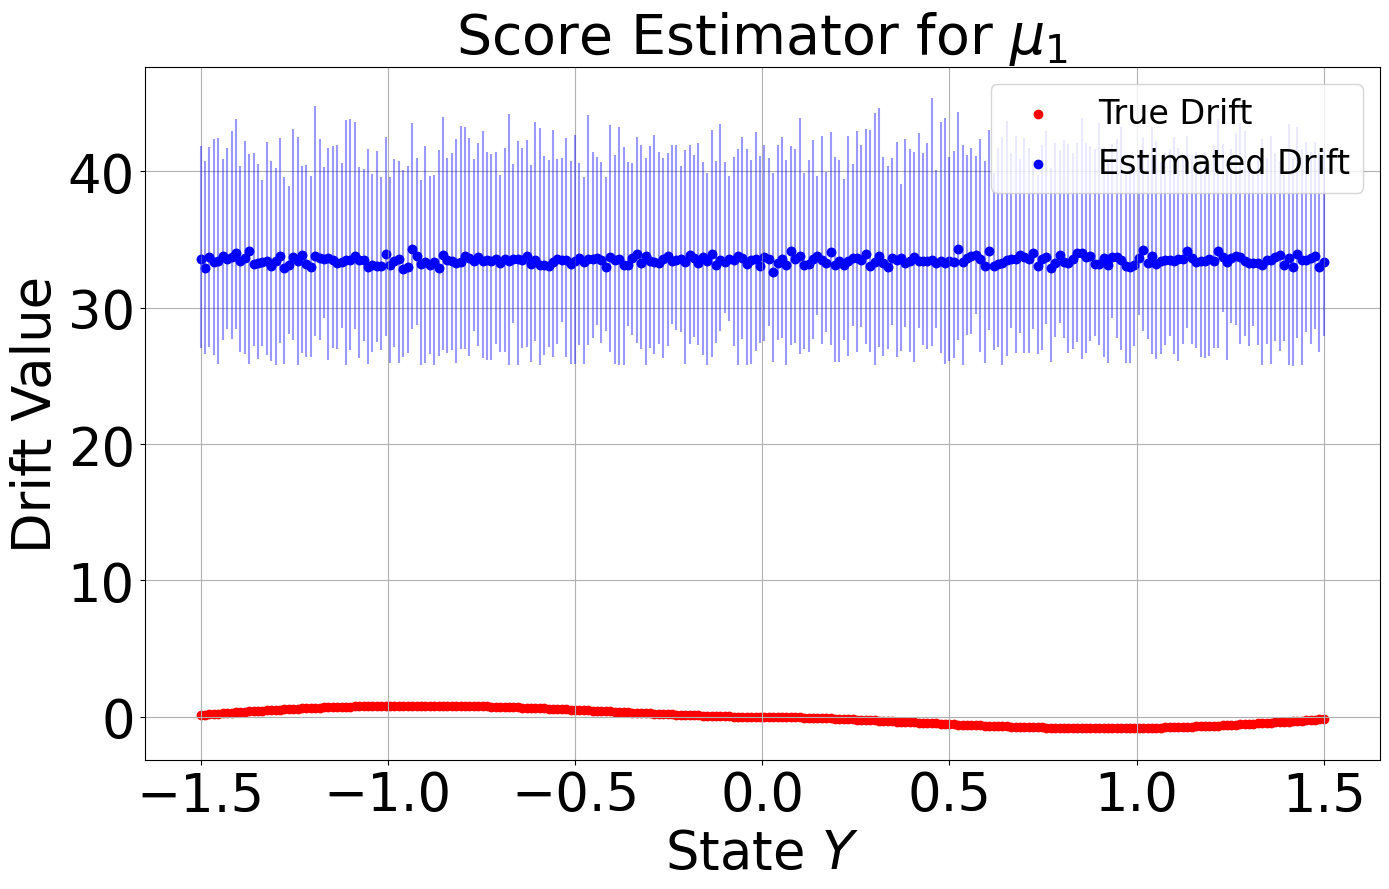

MSE 1121.421630859375 at Nepoch 51

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_2Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(52, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_3Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
3073.967529296875
(53, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_4Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
8233.21875
(54, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeL

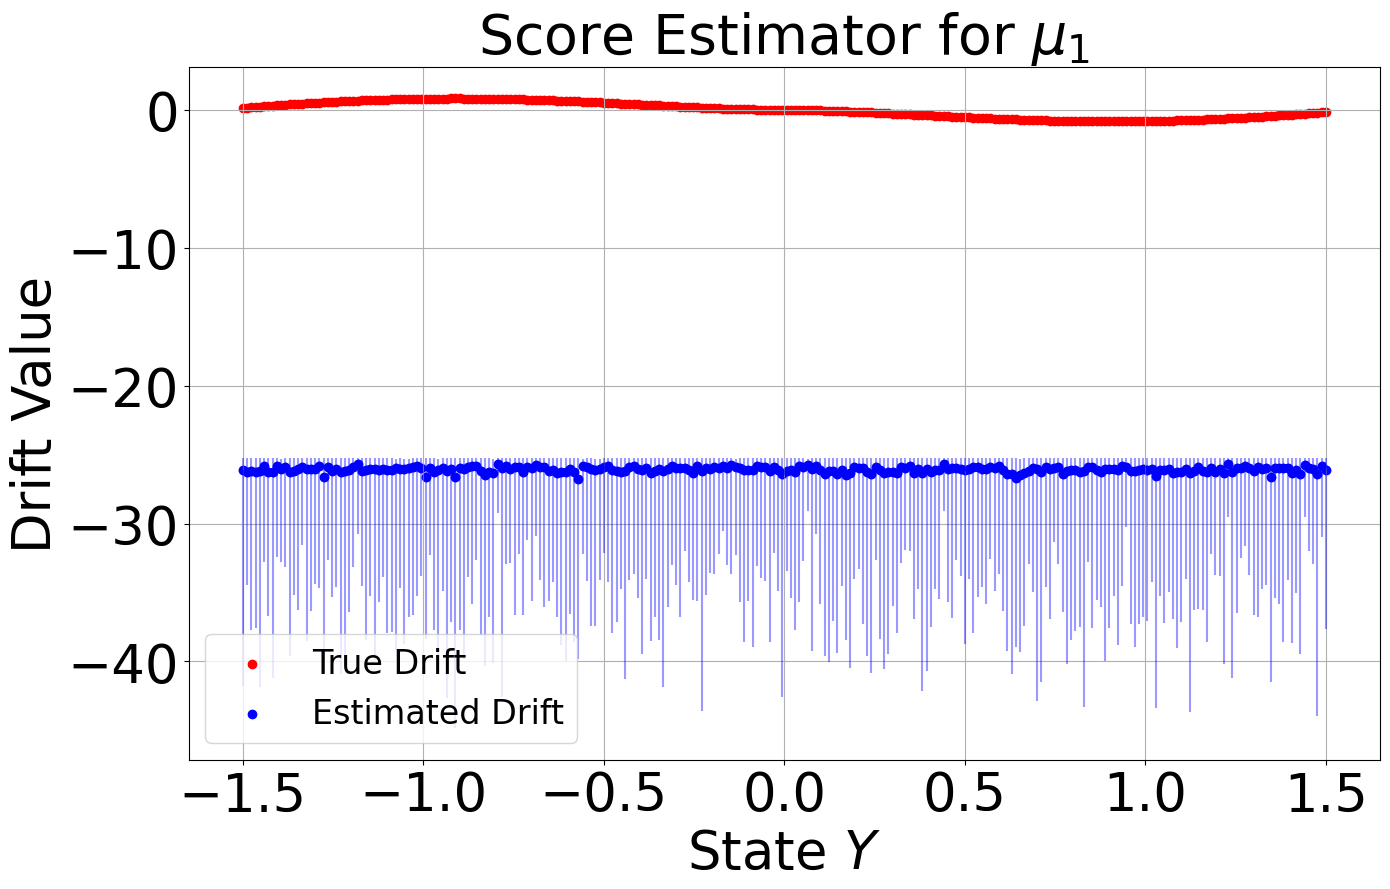

MSE 680.8859252929688 at Nepoch 56

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_7Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(57, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_8Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.592166006565094
torch.Size([256, 100])
(256,)


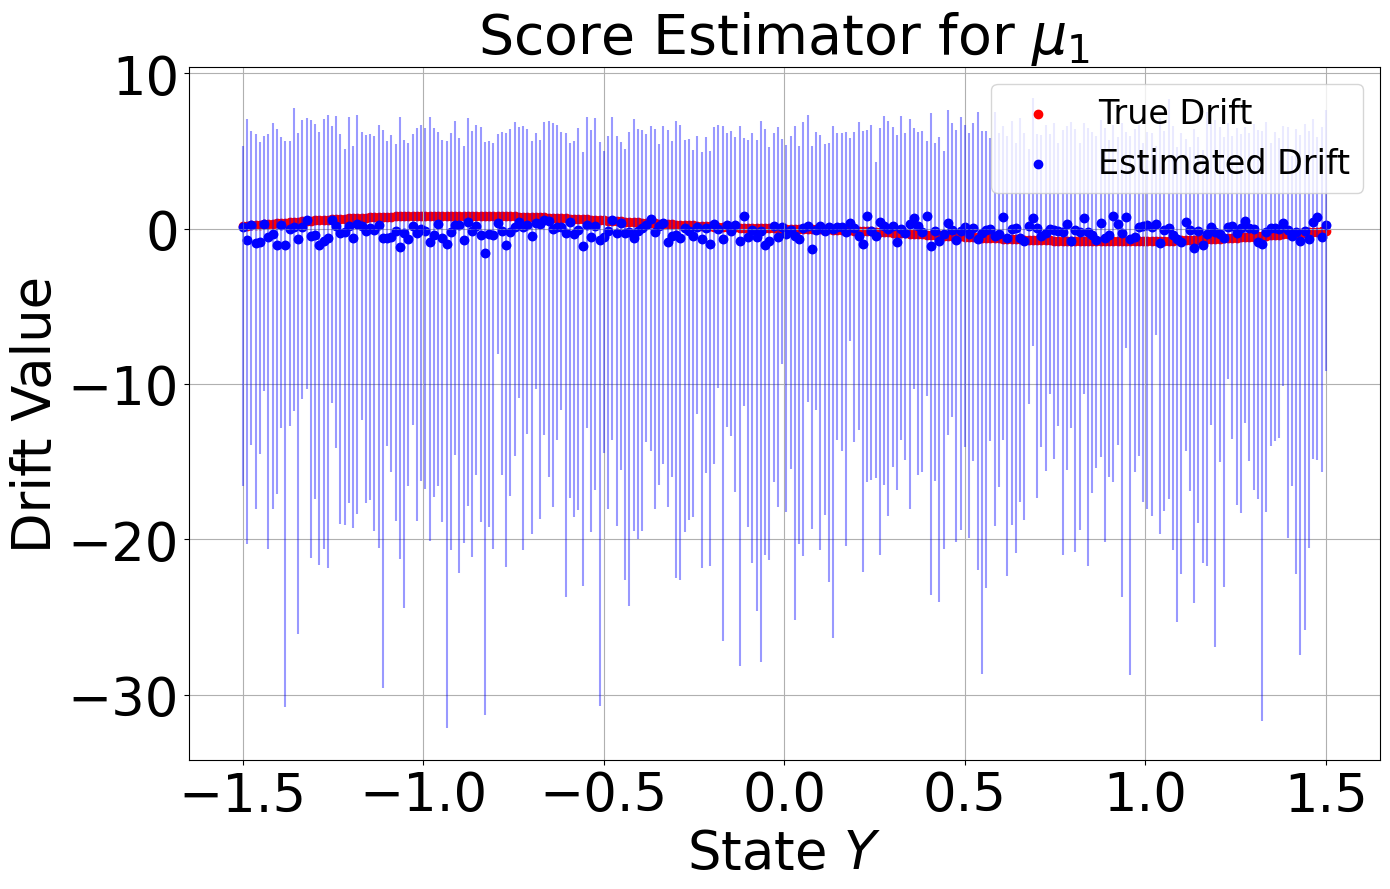

MSE 0.592166006565094 at Nepoch 57

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_8Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(58, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_9Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
338.9988708496094
(59, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_10Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
833.27392578125
(60, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCo

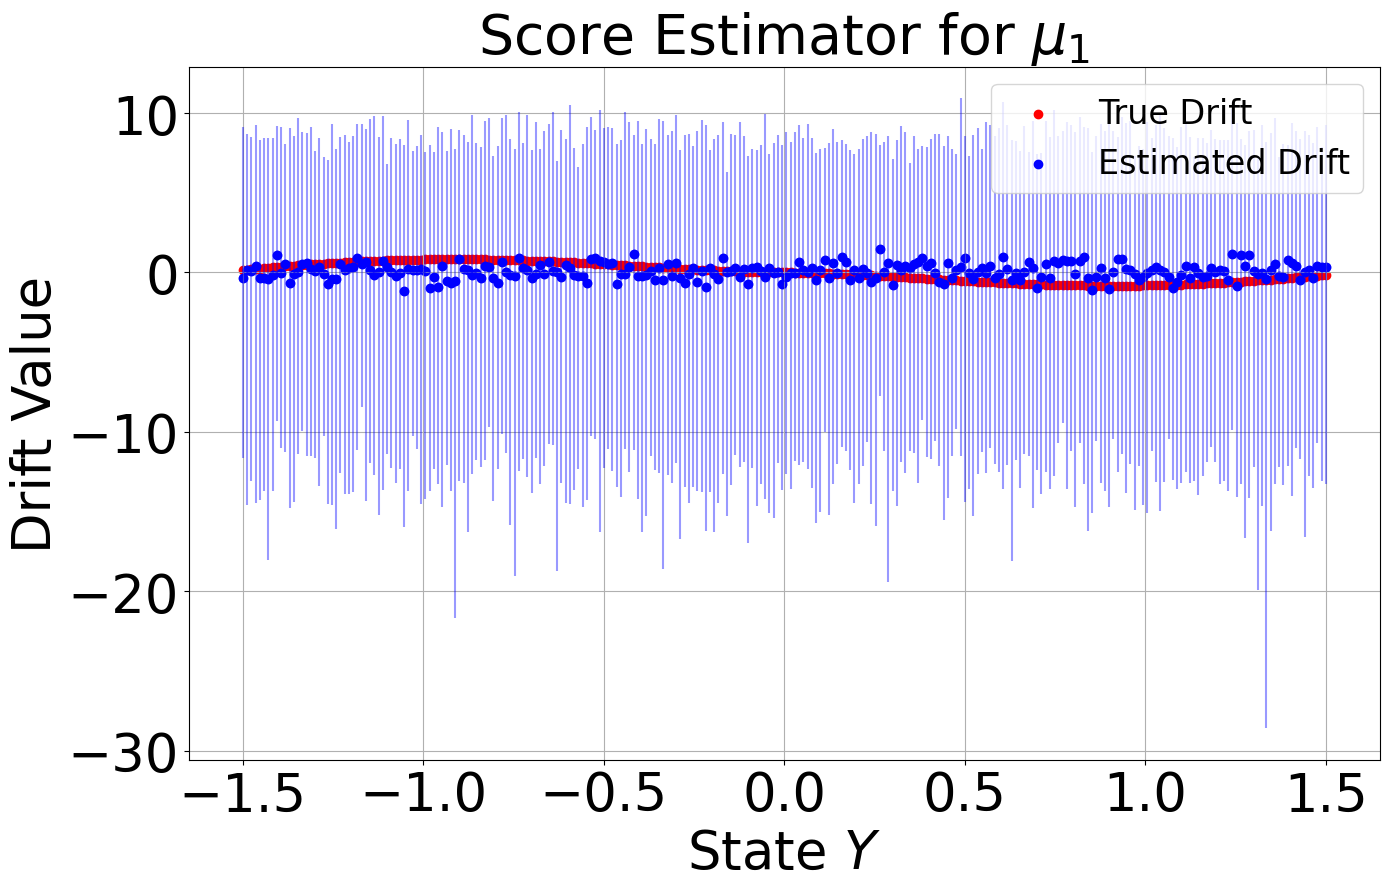

MSE 0.5847817659378052 at Nepoch 81

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_32Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(82, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_33Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
7.799537181854248
(83, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_34Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
24.117111206054688
(84, '/Users/marcos/Library/CloudStorage/OneDrive-Impe

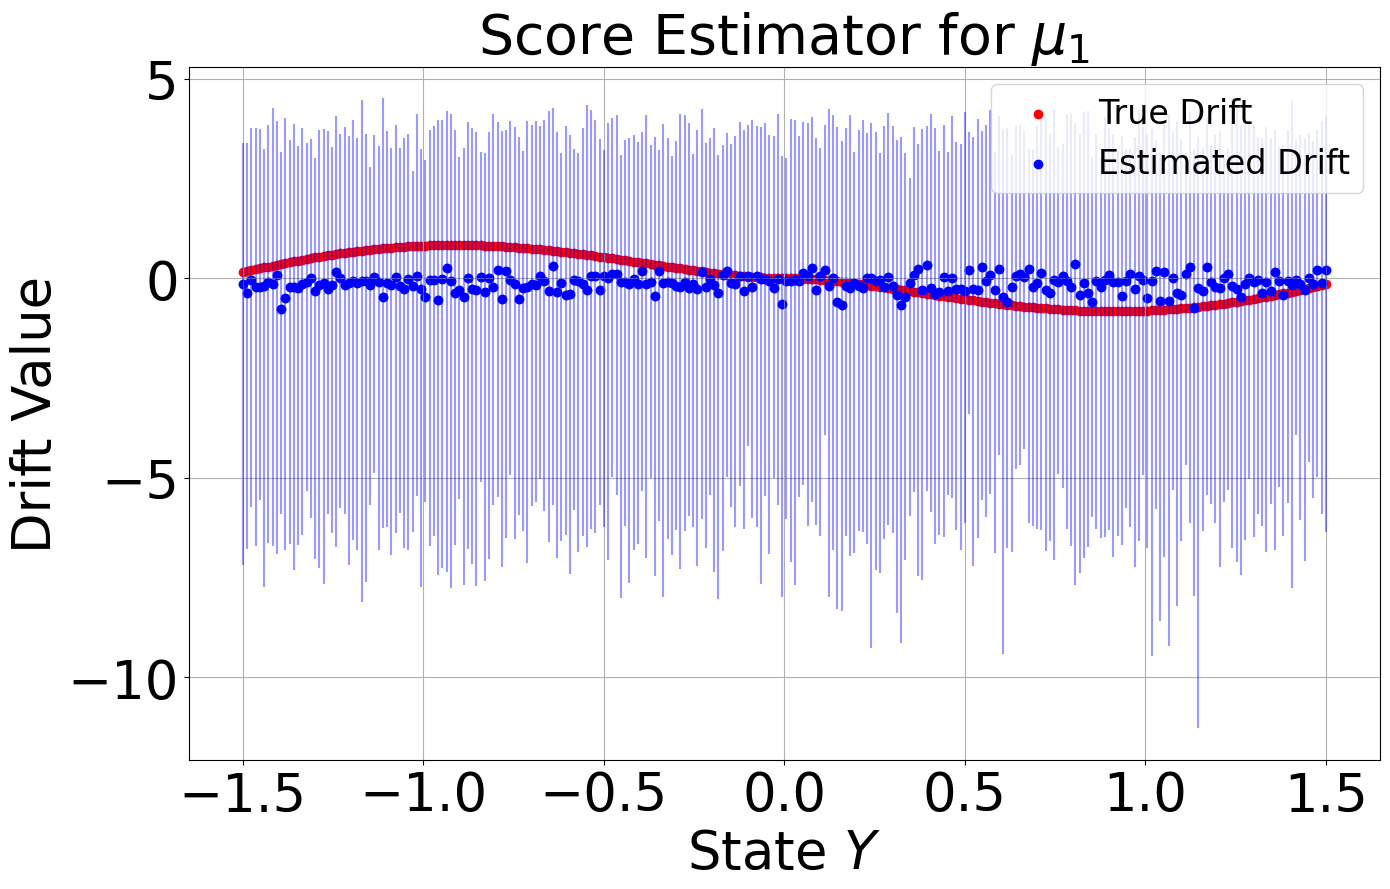

MSE 0.39138031005859375 at Nepoch 103

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_54Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(104, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_55Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.9003826975822449
(105, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_56Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
2.762946844100952
(106, '/Users/marcos/Library/CloudStorage/OneDrive

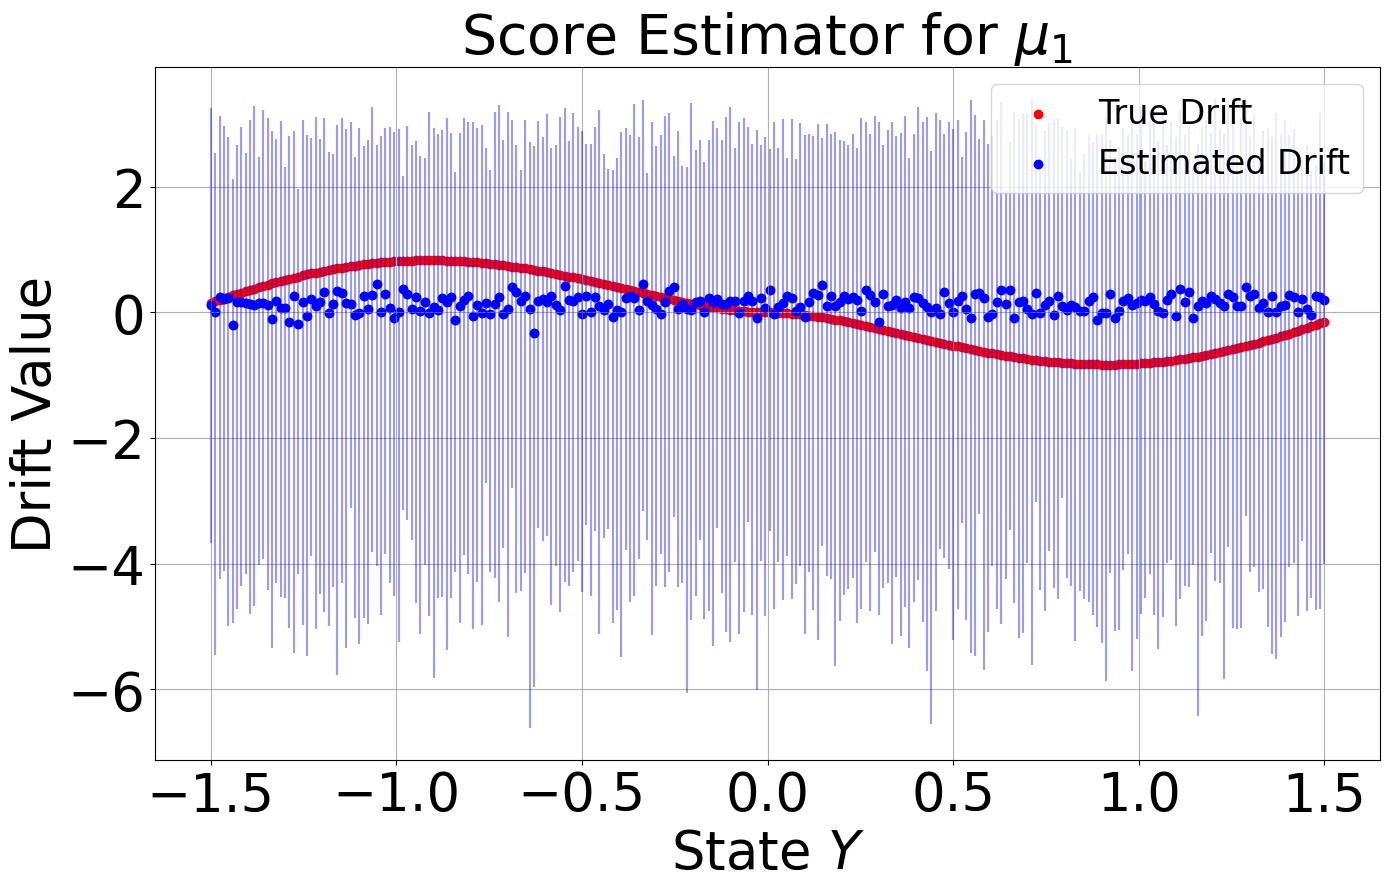

MSE 0.3645560145378113 at Nepoch 114

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_65Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(115, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_66Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.48835837841033936
(116, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_67Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.9260448217391968
(117, '/Users/marcos/Library/CloudStorage/OneDriv

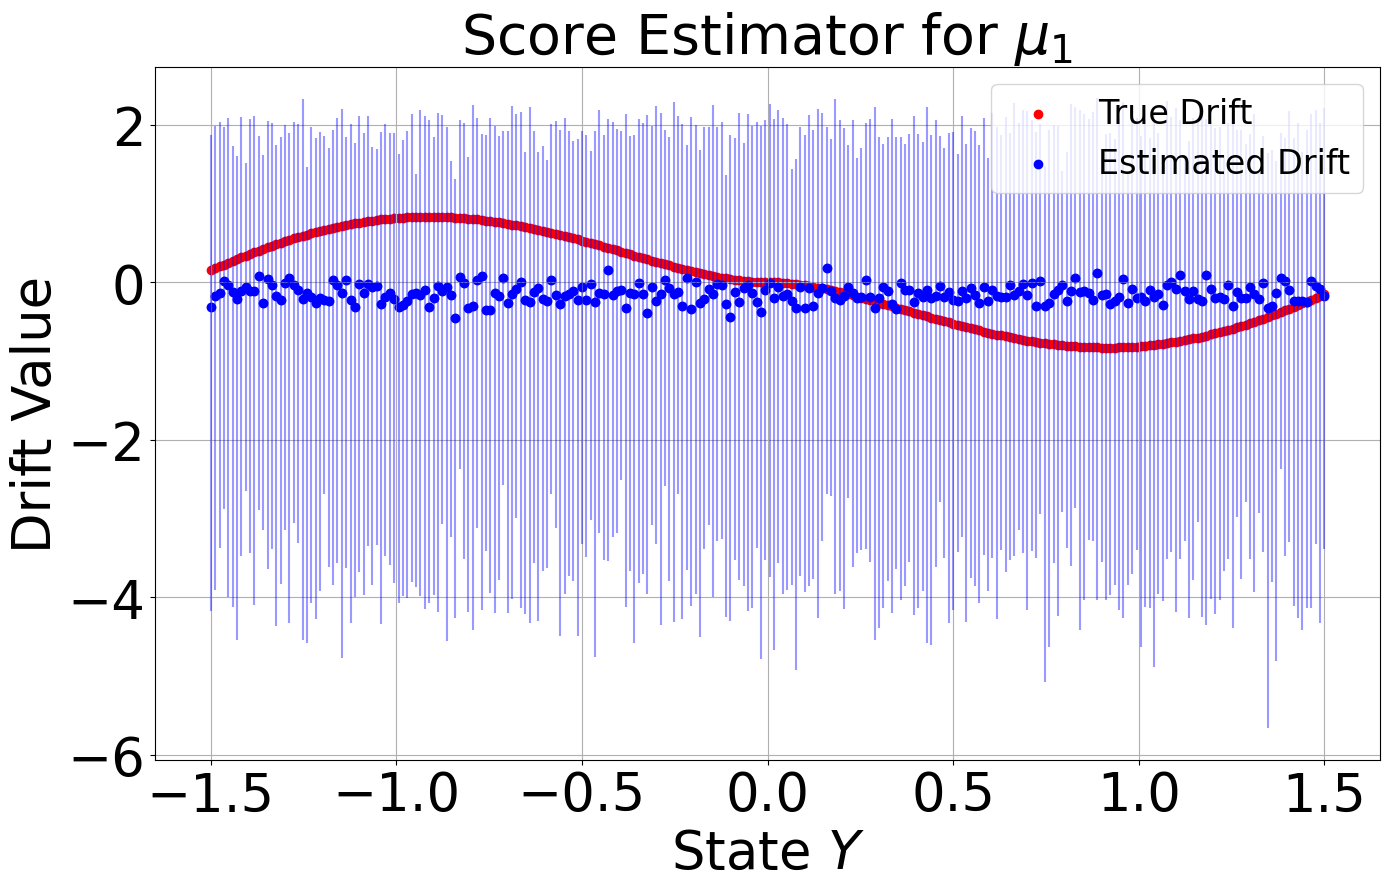

MSE 0.3604053556919098 at Nepoch 123

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_74Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(124, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_75Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.3746076822280884
(125, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_76Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.648775041103363
(126, '/Users/marcos/Library/CloudStorage/OneDrive-

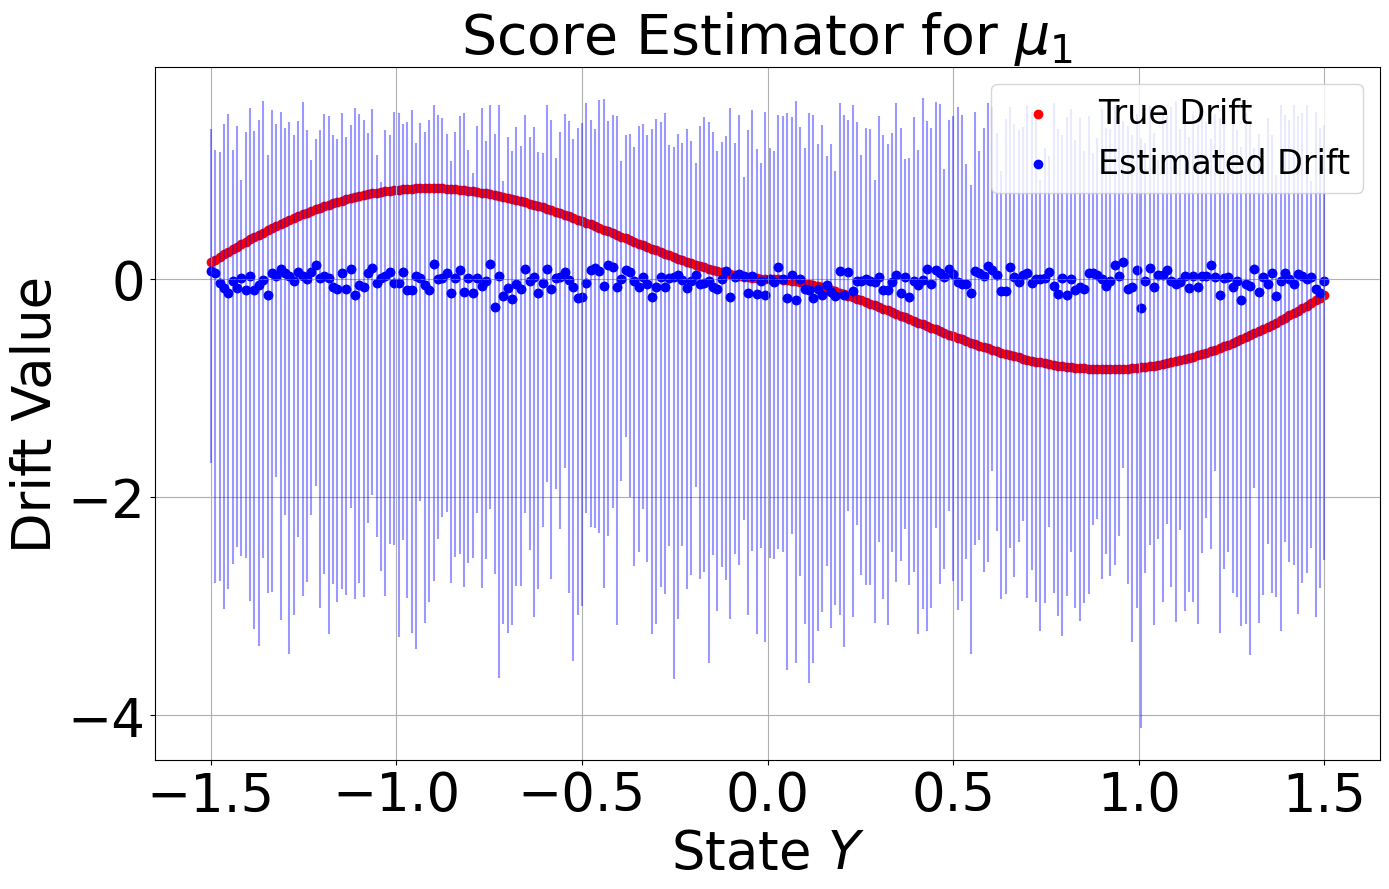

MSE 0.3346625566482544 at Nepoch 135

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_86Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(136, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_87Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.3742508292198181
(137, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_88Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.4147389233112335
(138, '/Users/marcos/Library/CloudStorage/OneDrive

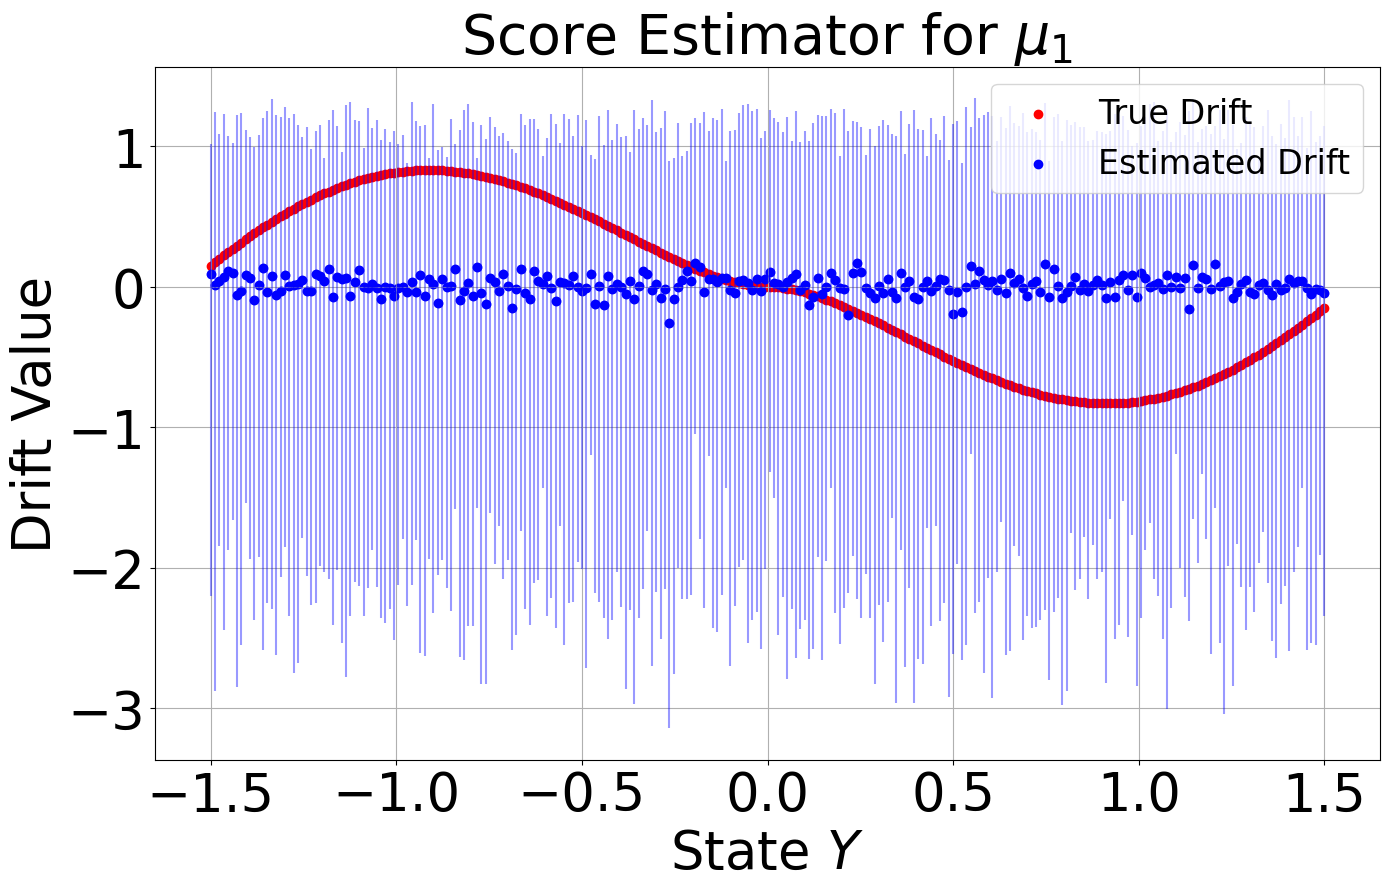

MSE 0.331795334815979 at Nepoch 142

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_93Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(143, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_94Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.3604588508605957
(144, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_95Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.4099254608154297
(145, '/Users/marcos/Library/CloudStorage/OneDrive-

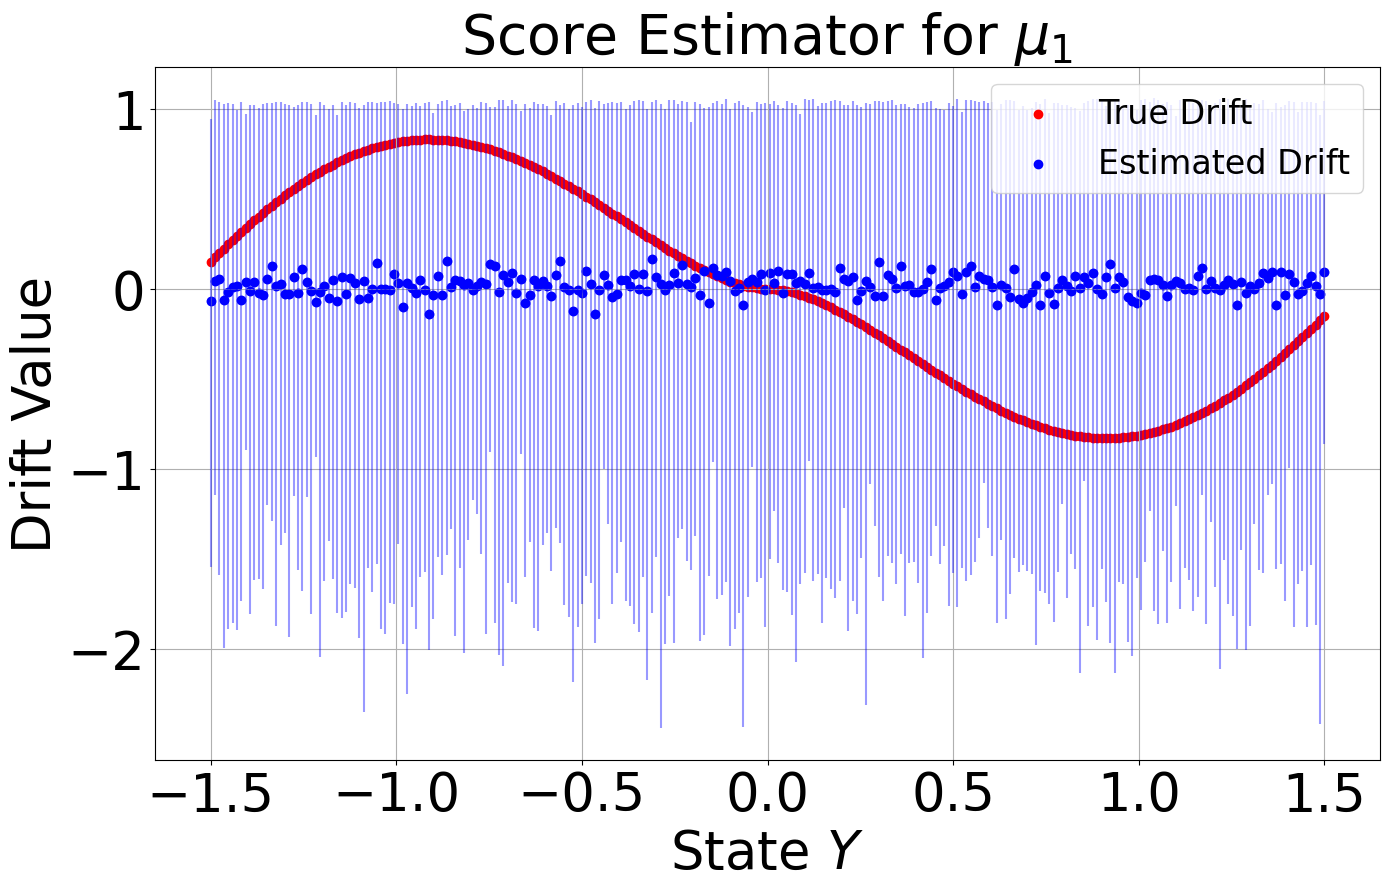

MSE 0.3289754092693329 at Nepoch 154

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_105Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(155, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_106Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.3280770778656006
torch.Size([256, 100])
(256,)


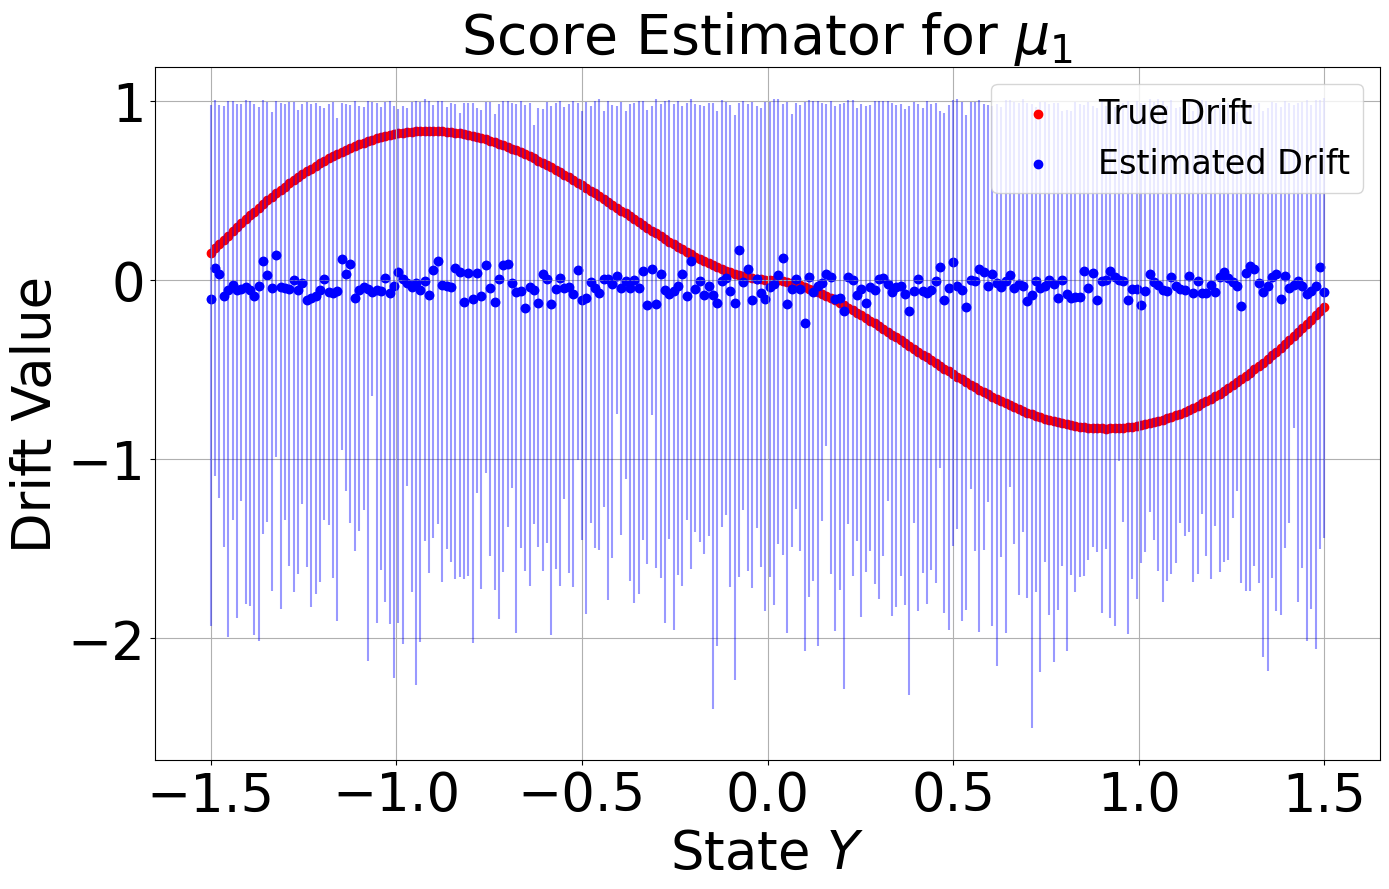

MSE 0.3280770778656006 at Nepoch 155

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_106Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(156, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_107Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.34258678555488586
(157, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_108Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.3321770429611206
(158, '/Users/marcos/Library/CloudStorage/OneD

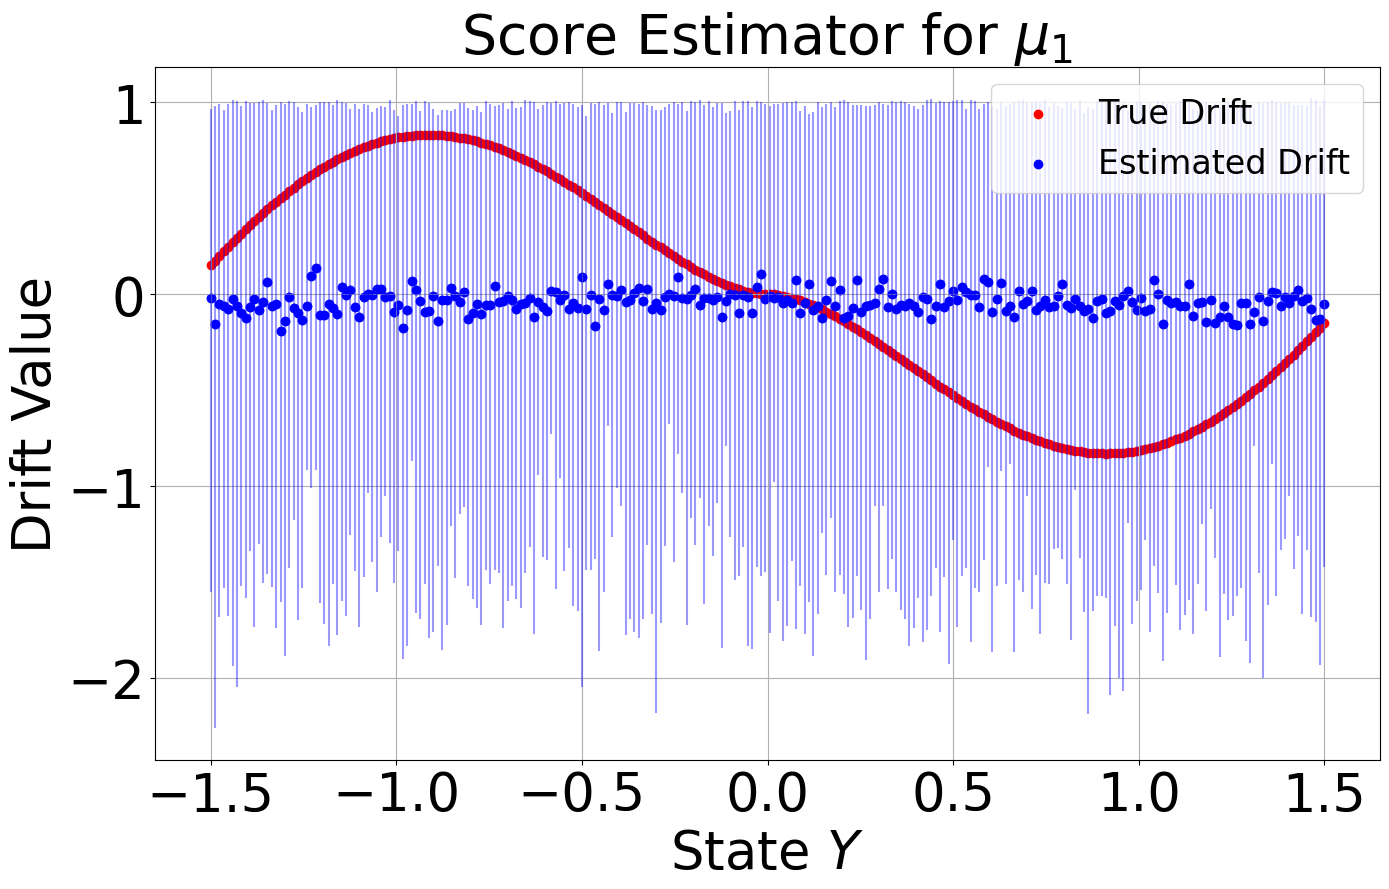

MSE 0.327133446931839 at Nepoch 158

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_109Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(159, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_110Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.3251608908176422
torch.Size([256, 100])
(256,)


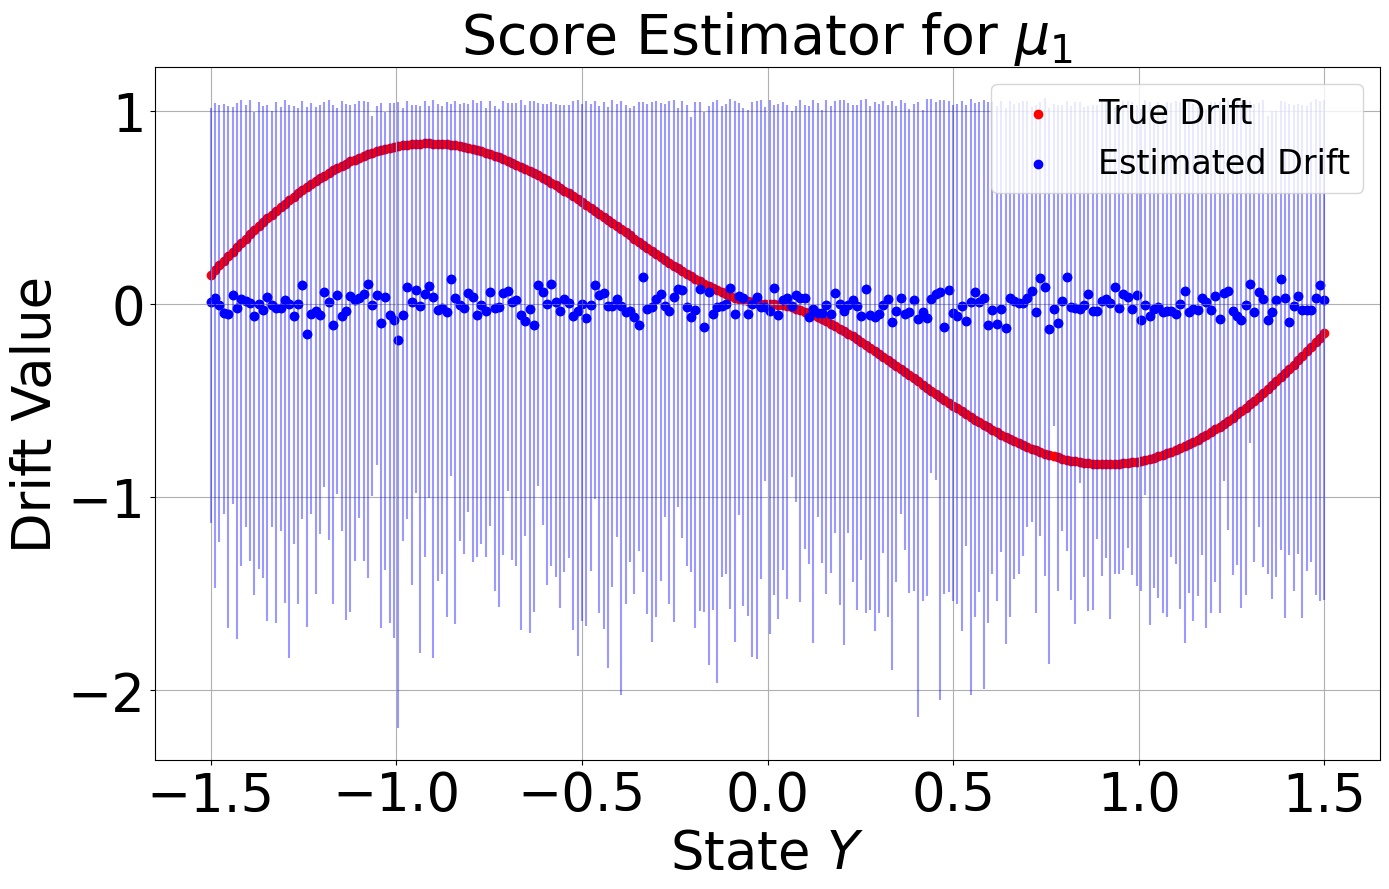

MSE 0.3251608908176422 at Nepoch 159

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_110Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(160, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_111Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.32460102438926697
torch.Size([256, 100])
(256,)


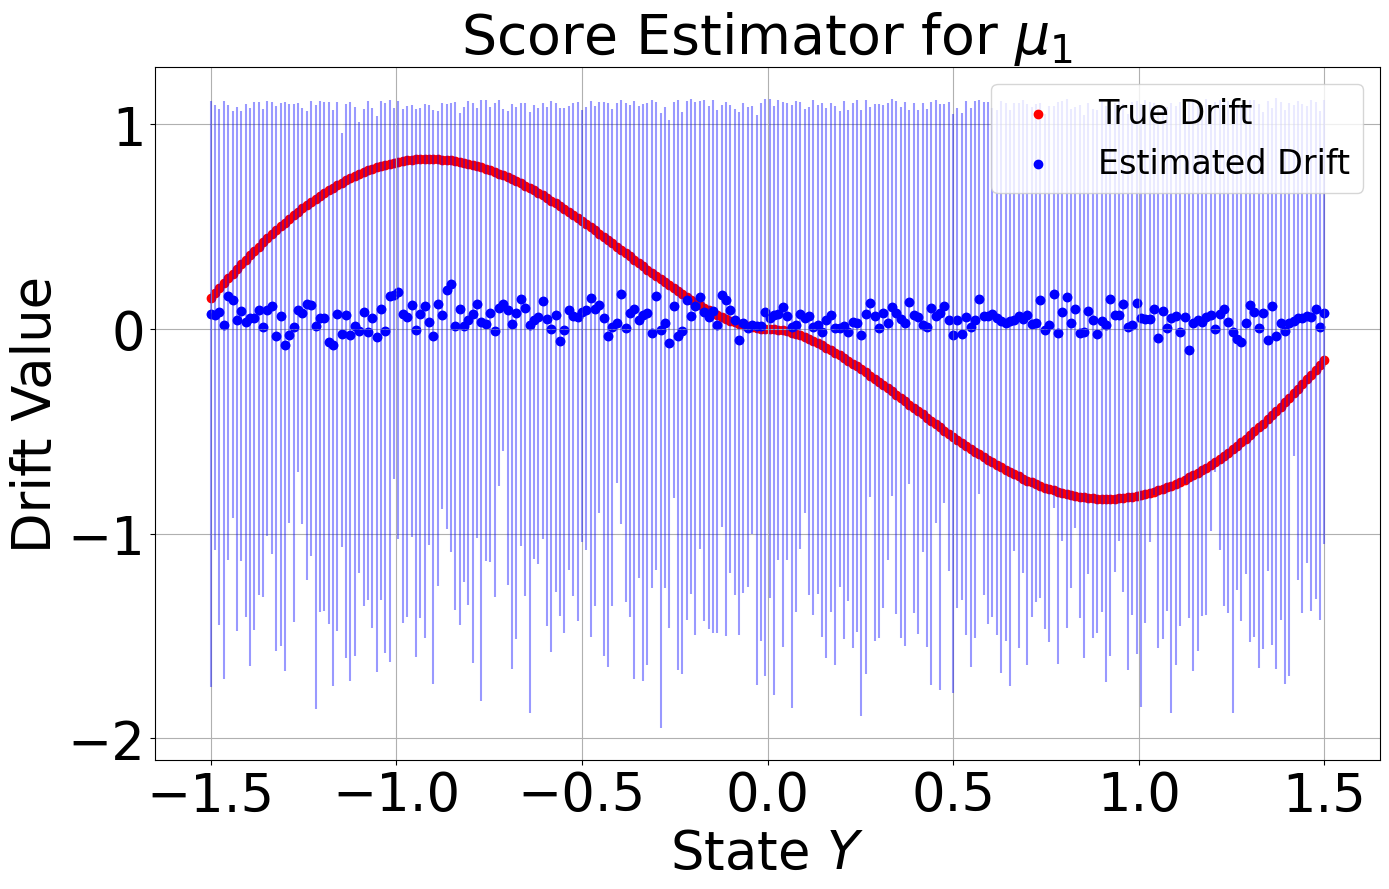

MSE 0.32460102438926697 at Nepoch 160

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_111Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(161, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_112Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.34297963976860046
(162, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_113Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.35610833764076233
(163, '/Users/marcos/Library/CloudStorage/On

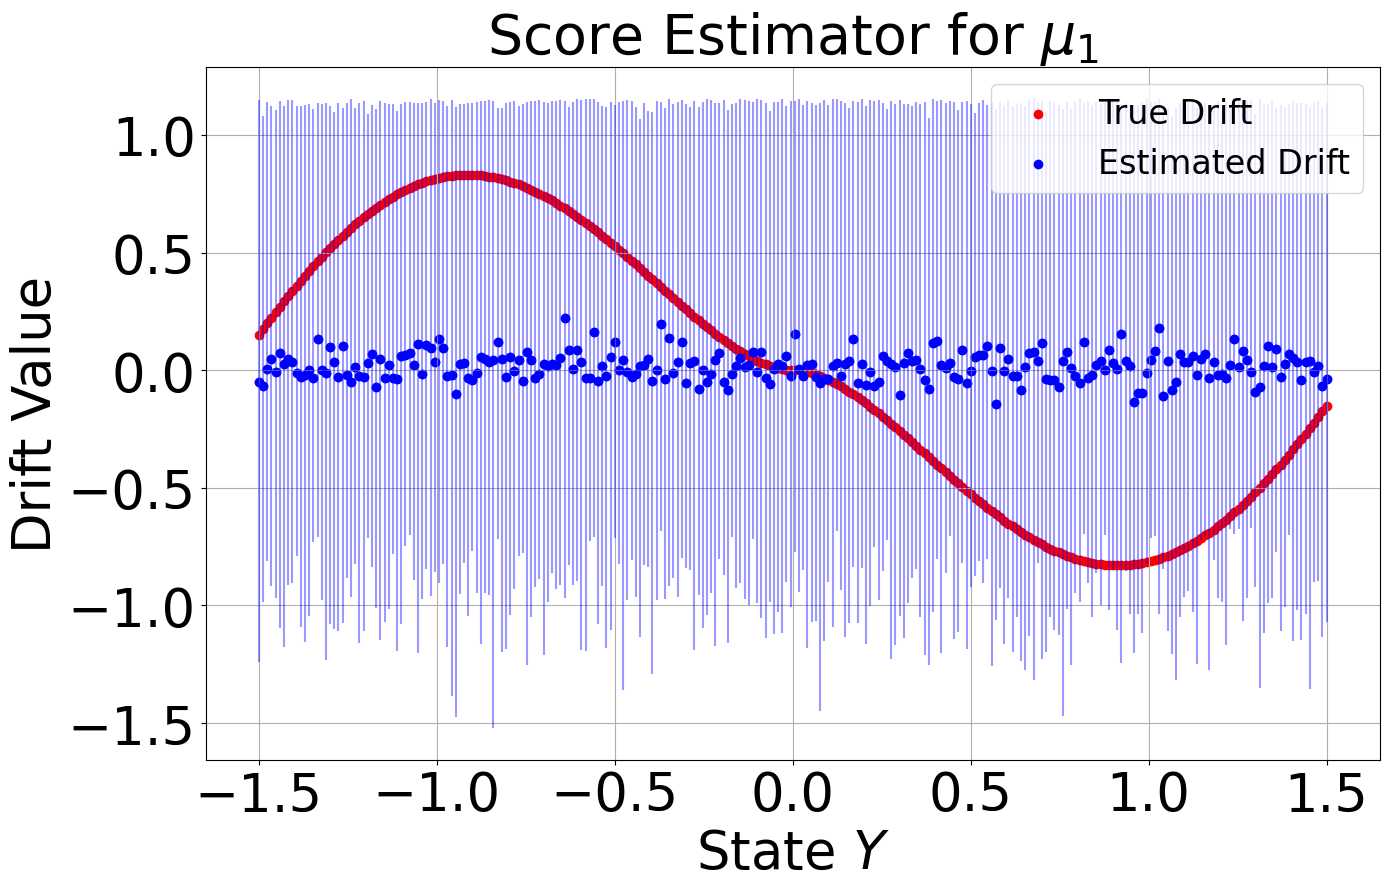

MSE 0.32363826036453247 at Nepoch 174

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_125Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
(175, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_126Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.334075391292572
(176, '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_DriftEvalExp_127Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_muhats.npy')
torch.Size([256, 100])
0.330234169960022
(177, '/Users/marcos/Library/CloudStorage/OneDri

In [51]:
best_rmse = np.inf
m_mu_hats = []
toSave = False
for f in zip(*[common_epochs, driftevalexp_files]):
    print(f)
    Nepoch = f[0]
    file = f[1]
    if Nepoch not in common_epochs: continue
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        elif "SinLog" in config.data_path:
            true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale).numpy()
        #print(Nepoch, muhats.shape, true_drifts.shape)
        muhats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[2]*1)
        print(muhats.shape)
        mu_hats = muhats.mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        print(rmse)
        if rmse < best_rmse:
            print(muhats.shape)
            mu_hats_minq = muhats.quantile(dim=-1, q=0.005).numpy() # Lower bound
            mu_hats_maxq = muhats.quantile(dim=-1, q=0.995).numpy() # Upper boun
            best_rmse = rmse
            print(mu_hats_maxq.shape)
            plot_drift_estimator(mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, dirname=dirname, numpy_Xs=Xs.numpy(),  toSave=toSave, true_drift=true_drifts, Nepoch=Nepoch, label=label)
            print(f"MSE {rmse} at Nepoch {Nepoch}\n")
            print(file)
    except FileNotFoundError as e:
        print(f"{e}, Hi")
#m_mu_hats = torch.Tensor(np.array(m_mu_hats))
#m_mu_hats = m_mu_hats.numpy()
#mu_hats = m_mu_hats.mean(axis=0)


110 ('/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_OOSDriftTrack_122Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_OOSDriftTrack_122Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_global_states.npy', 110)


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_5588/3014505768.py:15: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean((all_local_errors), axis=0))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_5588/3014505768.py:16: RuntimeWarning: invalid value encountered in divide
  all_errs = np.sqrt(all_local_errors)/np.sqrt(time_steps)


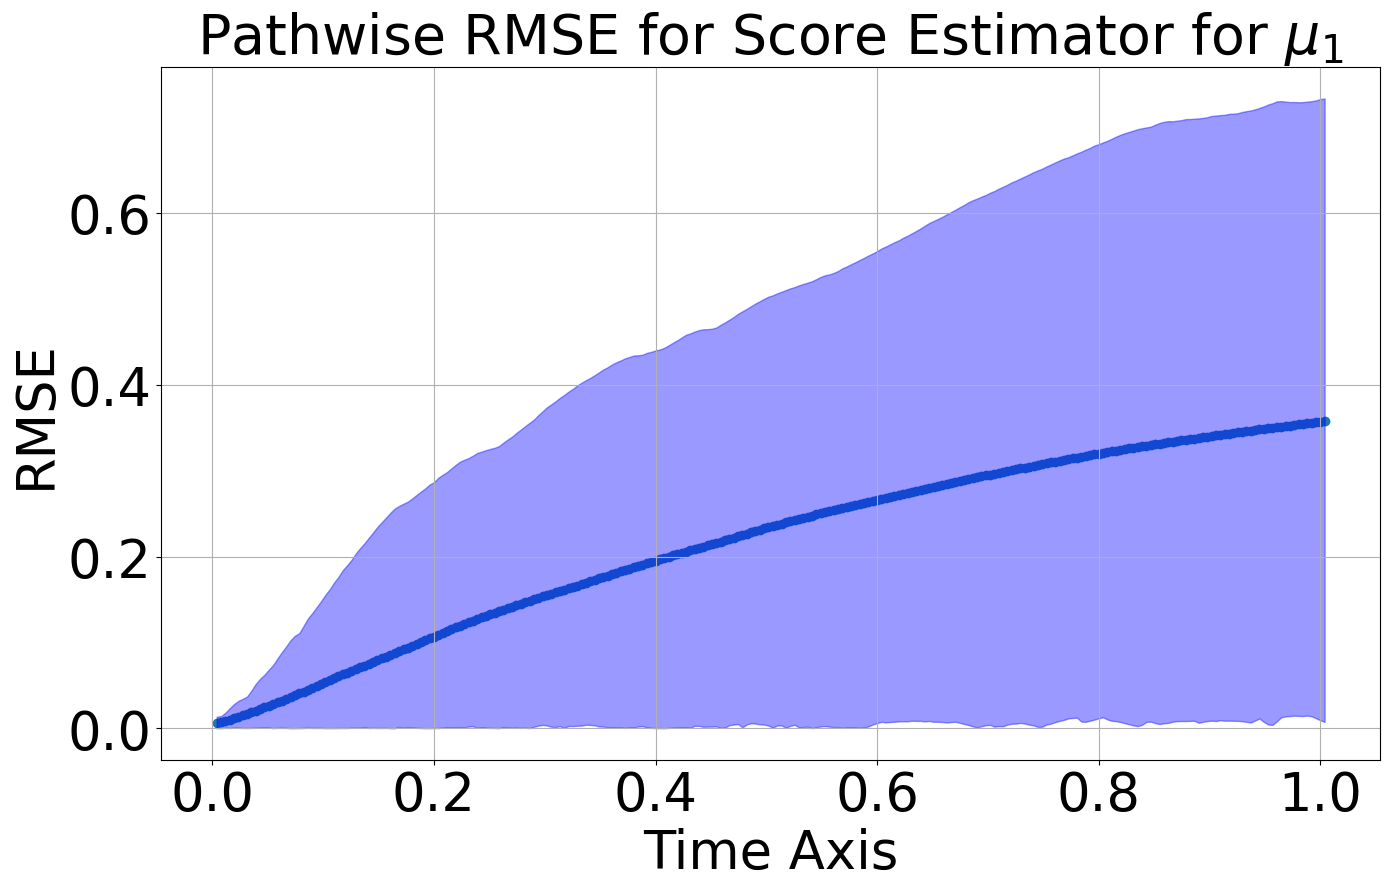

Final time cumulative MSE local-time error 0.3576373712178791 with IQR ((0.007477433487445558, 0.7332223987227299))at Nepoch 110

('/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_OOSDriftTrack_122Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_OOSDriftTrack_122Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_global_states.npy', 110)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/SinLogLessData/.TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fSinLog_OOSDriftTrack_420Nep_00t0_3906e-03dT_50b_20c_10ResLay_2LFac_BetaMax20e+01_global_states.npy.TDW4OL'

In [52]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[driftoostrack_true_files, driftoostrack_local_files, common_epochs]):
    Nepoch = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if Nepoch != best_epoch_track:
        continue
    print(Nepoch, file)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_local_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_local_errors = all_local_errors.reshape(-1, all_local_errors.shape[-1])
        total_local_errors = np.sqrt(np.mean((all_local_errors), axis=0))/np.sqrt(time_steps)
        all_errs = np.sqrt(all_local_errors)/np.sqrt(time_steps)
        total_local_errors[np.isinf(total_local_errors)] = 0.
        all_errs[np.isinf(all_errs)] = 0.
        total_local_errors_minq, total_local_errors_maxq = np.quantile(all_errs, axis=0,q=[0.005,0.995])
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(f"Pathwise RMSE for Score Estimator for {label}",fontsize=40)

            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)

            fig.canvas.draw()
            # Get the offset text (e.g., '1e-5')
            offset_text = ax.yaxis.get_offset_text().get_text()

            # Remove the offset text from the axis
            ax.yaxis.get_offset_text().set_visible(False)

            # Inject the scale into the y-axis label
            if offset_text:
                ax.set_ylabel(f'RMSE ({offset_text})', fontsize=38)
            else:
                ax.set_ylabel('RMSE', fontsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 7)}_MinIQR_{round(total_local_errors_maxq[-1], 7)}_MaxIQR").replace(".", "")+".png")
            plt.grid(True)
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at Nepoch {Nepoch}\n")
            print(file)